In [1]:
import numpy as np
from helpers import *
import cv2
import matplotlib.pyplot as plt

In [2]:
im1 = cv2.imread("data/sequence/000001.png")
im2 = cv2.imread("data/sequence/000002.png")
im3 = cv2.imread("data/sequence/000003.png")
K = np.loadtxt('data/K.txt')

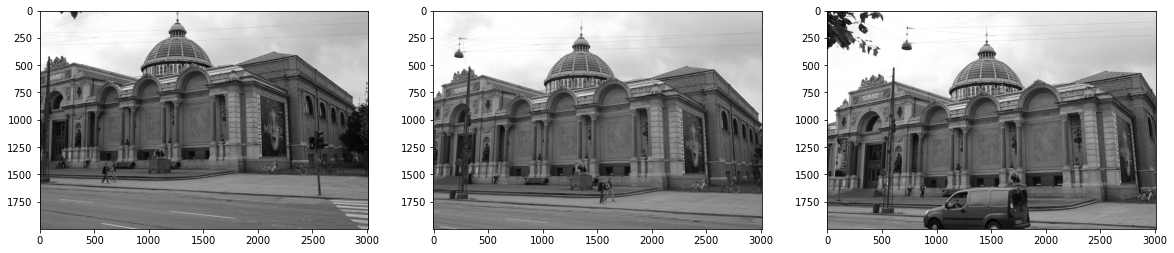

In [3]:
fig, axs = plt.subplots(1,3,figsize=(20, 8))
axs[0].imshow(im1)
axs[1].imshow(im2)
axs[2].imshow(im3)

In [4]:
sift = cv2.SIFT_create()
kp0_raw, des0 = sift.detectAndCompute(im1,None)
kp0, des0 = kp0_raw, des0
kp0 = np.array([k.pt for k in kp0])
kp1_raw, des1 = sift.detectAndCompute(im2,None)
kp1, des1 = kp1_raw, des1
kp1 = np.array([k.pt for k in kp1])
kp2_raw, des2 = sift.detectAndCompute(im3,None)
kp2, des2 = kp2_raw, des2
kp2 = np.array([k.pt for k in kp2])

In [5]:
bf = cv2.BFMatcher_create(crossCheck=True)
matches01 = bf.match(des0, des1)
matches01_raw = sorted(matches01, key = lambda x:x.distance)
matches01 = np.array([(m.queryIdx, m.trainIdx) for m in matches01_raw[:2000]])

matches12 = bf.match(des1, des2)
matches12 = sorted(matches12, key = lambda x:x.distance)
matches12 = np.array([(m.queryIdx, m.trainIdx) for m in matches12[:2000]])

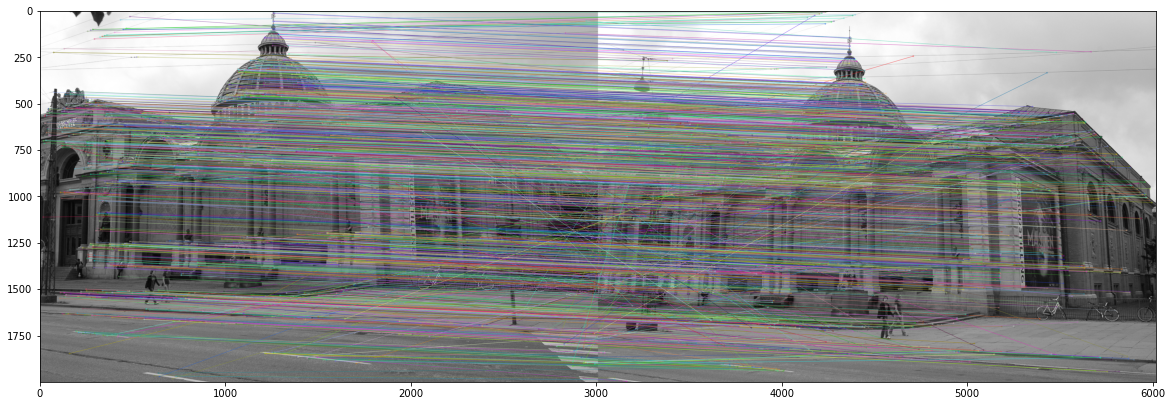

In [6]:
img3 = cv2.drawMatches(im1,kp0_raw,im2,kp1_raw,matches01_raw[:2000],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(img3)

In [7]:
points1 = kp0[matches01[:,0]]
points2 = kp1[matches01[:,1]]
points3 = kp2[matches12[:,1]]
E,_ = cv2.findEssentialMat(points1,points2,K)
E

array([[ 0.00235752,  0.27214714, -0.0298444 ],
       [-0.2755406 ,  0.03293248, -0.64899152],
       [ 0.04893722,  0.65080801,  0.0299432 ]])

In [8]:
retval, R, t, mask = cv2.recoverPose(E,points1,points2)
-R.T.dot(t), R.T, retval

(array([[ 0.91834304],
        [-0.0509964 ],
        [-0.39248622]]),
 array([[ 0.99992016,  0.00994076,  0.0078009 ],
        [-0.0095672 ,  0.9988704 , -0.04654459],
        [-0.00825477,  0.04646624,  0.99888575]]),
 1955)

In [9]:
# remove the matches that are not in both images
points1 = points1[(mask==255).reshape(-1)]
points2 = points2[(mask==255).reshape(-1)]
(mask==255).sum(), mask.shape, points1.shape

(1955, (2000, 1), (1955, 2))

In [10]:
matches01 = matches01[(mask==255).reshape(-1)]

In [11]:
_, idx01, idx12 = np.intersect1d(matches01[:,1], matches12[:,0], return_indices=True)
fmatches01 = matches01[idx01]
fmatches12 = matches12[idx12]
matches01.shape,matches12.shape,fmatches01.shape,fmatches12.shape

((1955, 2), (2000, 2), (652, 2), (652, 2))

In [12]:
fpoints1 = kp0[fmatches01[:,0]]
fpoints2 = kp1[fmatches01[:,1]]
fpoints3 = kp2[fmatches12[:,1]]

In [13]:
P1 = K @ np.concatenate((np.eye(3),np.zeros((3,1))),axis=1)
P2 = K @ np.concatenate((R,t),axis=1)
triang = cv2.triangulatePoints(P1,P2,fpoints1.T,fpoints2.T)
triang = (triang / triang[3,:])

In [14]:
retval, rvec, tvec, inliers = cv2.solvePnPRansac(triang[:3].T, fpoints3, K, None)
retval

True

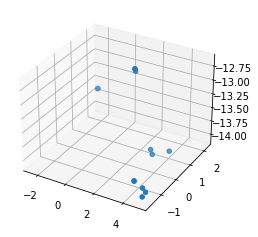

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = triang[:3].T[inliers.flatten()][:,0]
y = triang[:3].T[inliers.flatten()][:,1]
z = triang[:3].T[inliers.flatten()][:,2]
ax.scatter(x,y,z)

In [16]:
rot, _ = cv2.Rodrigues(rvec)
tvec = -rot.T.dot(tvec)

In [17]:
np.zeros((3,1)), -R.T.dot(t), tvec # looks like smth reasonable!

(array([[0.],
        [0.],
        [0.]]),
 array([[ 0.91834304],
        [-0.0509964 ],
        [-0.39248622]]),
 array([[ 1.96493734],
        [-0.19215526],
        [-1.13210084]]))

In [18]:
tsss = []

In [19]:
retval, rvec, tvec, inliers = cv2.solvePnPRansac(triang[:3].T, fpoints1, K, None)
rot, _ = cv2.Rodrigues(rvec)
tvec = -rot.T.dot(tvec)
tsss.append(tvec)
tvec

array([[ 0.0004394 ],
       [-0.00440732],
       [-0.0010591 ]])

In [20]:
retval, rvec, tvec, inliers = cv2.solvePnPRansac(triang[:3].T, fpoints2, K, None)
rot, _ = cv2.Rodrigues(rvec)
tvec = -rot.T.dot(tvec)
tsss.append(tvec)
tvec

array([[ 0.91813097],
       [-0.04689164],
       [-0.39111526]])

In [21]:
retval, rvec, tvec, inliers = cv2.solvePnPRansac(triang[:3].T, fpoints3, K, None)
rot, _ = cv2.Rodrigues(rvec)
tvec = -rot.T.dot(tvec)
tsss.append(tvec)
tvec

array([[ 1.96493734],
       [-0.19215526],
       [-1.13210084]])

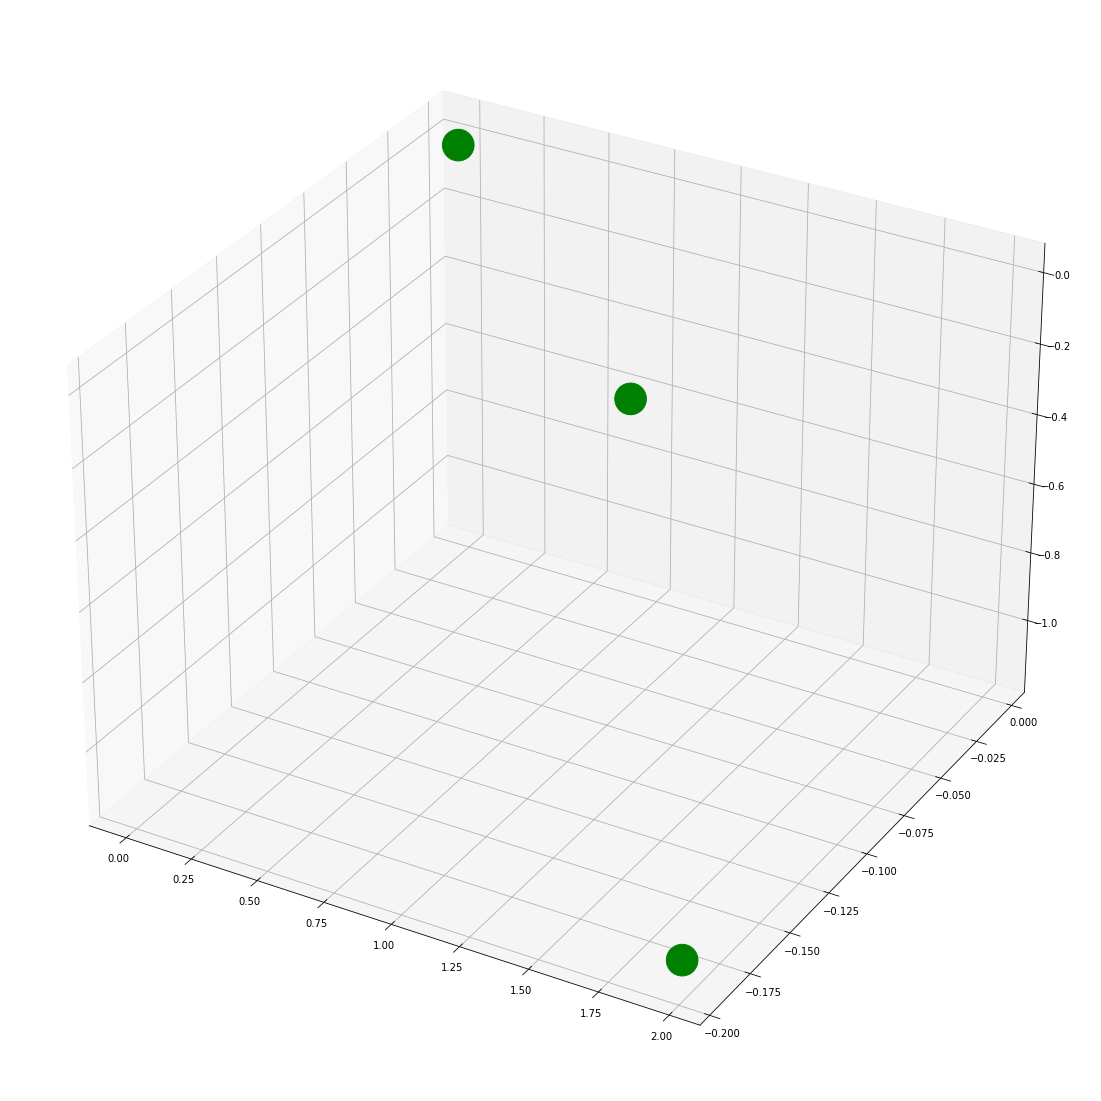

In [22]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
x = np.array(tsss).reshape(3,3)[:,0]
y = np.array(tsss).reshape(3,3)[:,1]
z = np.array(tsss).reshape(3,3)[:,2]
ax.scatter(x,y,z,c='g',s=1000,alpha=1)